## ARIMA on the shampoo dataset

From: Vicente Guerrero

https://viclule.github.io/

Date: 14.03.2019


Based on the article from Jason Brownlee.
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

##### Shampoo Sales Dataset
This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

#### ARIMA Model
is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

    AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

    I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

    MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
    
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# load dataset
def parser(x):
    return pd.datetime.strptime('201'+x, '%Y-%m')

df = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

Month
2011-01-01    266.0
2011-02-01    145.9
2011-03-01    183.1
2011-04-01    119.3
2011-05-01    180.3
Name: Sales, dtype: float64

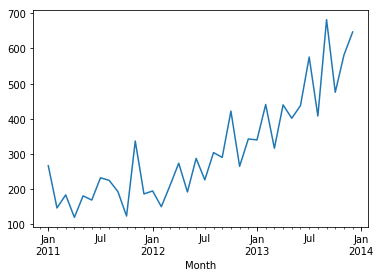

In [3]:
df.plot()
plt.show()

#### 1. Baseline model
Persistence Model Forecast.

The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

In [4]:
# split data into train and test
values = df.values
train, test = values[0:-12], values[-12:]

RMSE: 136.761


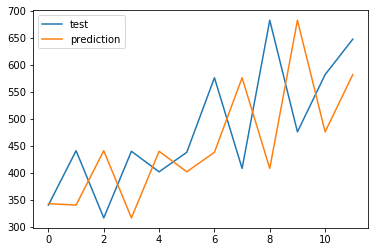

In [5]:
# walk-forward validation
history = train
predictions = np.zeros(len(test))
for i, x in enumerate(test):
    # make prediction
    predictions[i] = history[-1]
    # observation
    history = np.append(history, x)
# report performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test, label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

#### 2. Autocorrelation in the data

c:\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


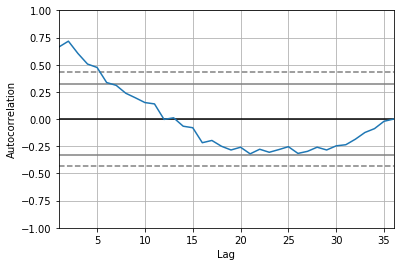

In [6]:
pd.tools.plotting.autocorrelation_plot(df)
plt.show()

We can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

#### 3. Fit an ARIMA Model

c:\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Thu, 14 Mar 2019   AIC                            406.340
Time:                        16:15:32   BIC                            417.227
Sample:                    02-01-2011   HQIC                           410.098
                         - 12-01-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

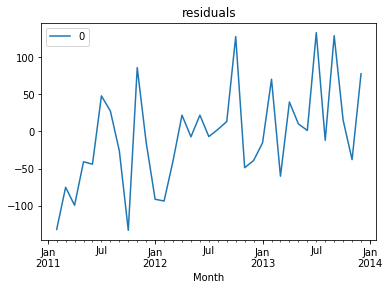

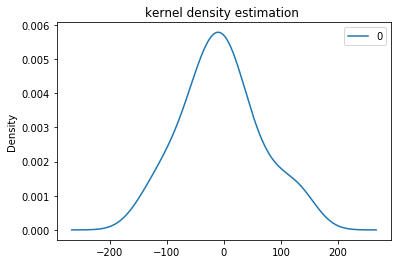

                0
count   35.000000
mean    -5.495215
std     68.132882
min   -133.296619
25%    -42.477920
50%     -7.186571
75%     24.748340
max    133.237965


In [7]:
# fit model
model = ARIMA(df, order=(5,1,0))  # p, d, q
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('kernel density estimation ')
plt.show()
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

[This is a good explanation of KDE's](https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28)

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

###### Autocorrelation in the residuals.
They do not show any large correlation, so it is a good signal of randomness

c:\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


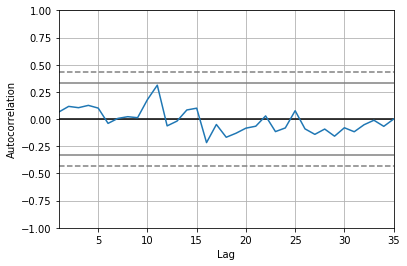

In [8]:
pd.tools.plotting.autocorrelation_plot(residuals)
plt.show()

#### 4. Rolling Forecast ARIMA Model
The ARIMA model can be used to forecast future time steps.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

In [9]:
values = df.values
size = int(values.shape[0] * 0.66)
train, test = values[0:size], values[size:]
history = train
predictions = np.zeros(test.shape[0])

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions[t] = yhat
    obs = test[t]
    history = np.append(history, obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=349.117590, expected=342.300000
predicted=306.512897, expected=339.700000
predicted=387.376377, expected=440.400000
predicted=348.154243, expected=315.900000
predicted=386.308882, expected=439.300000
predicted=356.082097, expected=401.300000
predicted=446.379430, expected=437.400000
predicted=394.737263, expected=575.500000
predicted=434.915489, expected=407.600000
predicted=507.923512, expected=682.000000
predicted=435.483013, expected=475.300000
predicted=652.743897, expected=581.300000
predicted=546.343515, expected=646.900000
Test RMSE: 83.417


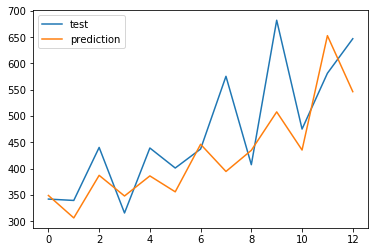

In [10]:
# plot
plt.plot(test, label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

RMSE: 83.417 ... It is much better than the baseline model (136.761)